Working on just the Mega-MUSCLES G140M spectra

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interpolate
from craftroom import resample
import stistools
from astropy.convolution import convolve, Box1DKernel

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20


In [15]:
datapath = 'raw_data/'
outpath = 'mm_x1ds/'
flts = glob.glob(datapath + '*flt.fits*')
oref="${CRDS_PATH}/references/hst/oref/"
ourroots = ['odlm41020','odlm41030','odlm41040','odlm41050']

odlm41020 needs the headers updated

In [16]:
raw = datapath+ourroots[0]+'_raw.fits'
hdul = fits.open(raw)

In [17]:
hdul[1].header['EXPTIME']

2709.999936330132

In [18]:
hdr = hdul[0].header
expt = (hdr['TEXPEND']  - hdr['TEXPSTRT']) * 86400
print(expt)
hdul.close()

2709.999936330132


In [19]:
fits.setval(raw, 'TEXPTIME', value=expt)
fits.setval(raw, 'EXPTIME',  ext=1, value=expt)

In [20]:
fits.getheader(raw,1)['EXPTIME']

2709.999936330132

In [21]:
stistools.calstis.calstis(raw, wavecal= datapath+'odlm41020_wav.fits',outroot=datapath+'odlm41020_new',  verbose=True, trailer='trl_files/odlm41020_recal.trl')

Appending to trailer file trl_files/odlm41020_recal.trl
Running calstis on raw_data/odlm41020_raw.fits
  ['cs0.e', '-v', 'raw_data/odlm41020_raw.fits', 'raw_data/odlm41020_new', '-w', 'raw_data/odlm41020_wav.fits']


1

In [22]:
mmflts = []
for flt in flts:
    if flt[-18:-9] in ourroots:
        mmflts.append(flt)
mmflts

['raw_data/odlm41020_flt.fits',
 'raw_data/odlm41040_flt.fits',
 'raw_data/odlm41030_flt.fits',
 'raw_data/odlm41050_flt.fits']

In [23]:
def build_trace_grid(SPTRCTAB, grating, cenwave):
    """
    Extends a grid of trace displacements to cover all y positions
    """
    data = fits.getdata(SPTRCTAB, 1)
    tracedata = data[(data['OPT_ELEM']==grating) & (data['CENWAVE'] == cenwave)]
    all_y = np.arange(len(tracedata[0]['A2DISPL']))
    grid = interpolate.interp1d(tracedata['A2CENTER'], tracedata['A2DISPL'], axis=0, fill_value='extrapolate')(all_y)
    tracegrid = [a+b for a, b in zip(grid, all_y)] 
    return tracegrid

def get_a2center(x, y, tracegrid):
    """
    get the trace a2center at a1center
    """
    xcol = np.array(tracegrid)[:,int(x)]
    xind = (np.abs(xcol - y)).argmin()
    a2center = xind + 1 #calstis is 1-indexed 
    return a2center

def no_zero_errors(flux, error):
    """
    Corrects instances where negative flux measurements have very small errors
    """
    e_new = error
    for i in range(len(error)):
        if flux[i] < 0.0 and error[i] < 0.1*abs(flux[i]):
            e_new[i] = abs(flux[i])
    return e_new

def new_coadd(f_array, e_array):
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    rcs = np.sum(((flux - f_array)**2) * weights, axis=0) / (len(f_array)-1)
    error = (var * rcs)**0.5
    return flux, error

In [24]:
centab = Table.read('mm_trace_centers.ecsv')
centab

ROOTNAME,XCOL,A2CENTER,UNCERTAIN
str9,float64,float64,float64
odlm41040,383.85317751133266,425.6280002264092,0.0
odlm41020,383.85317751133266,405.770329070397,0.0
odlm41030,382.7797898812779,404.69694144034236,0.0
odlm41050,386.5366465864694,405.770329070397,0.0


odlm41020
405.770329070397
406


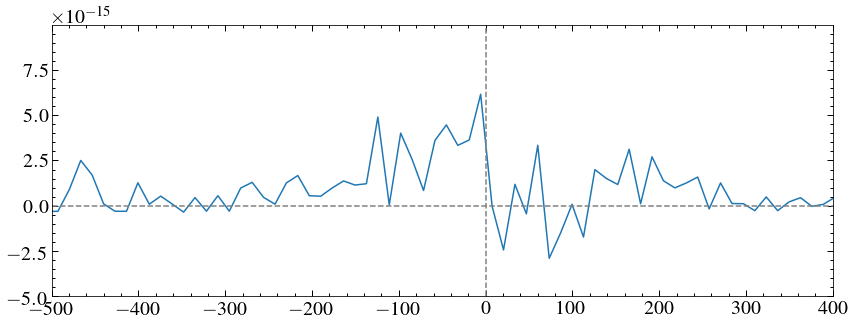

odlm41040
425.6280002264092
428


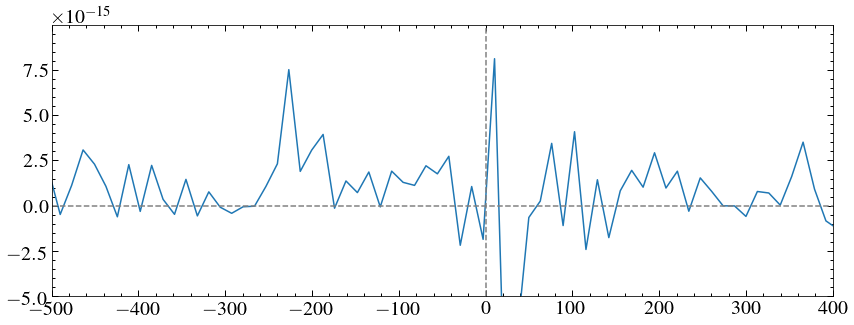

odlm41030
404.69694144034236
404


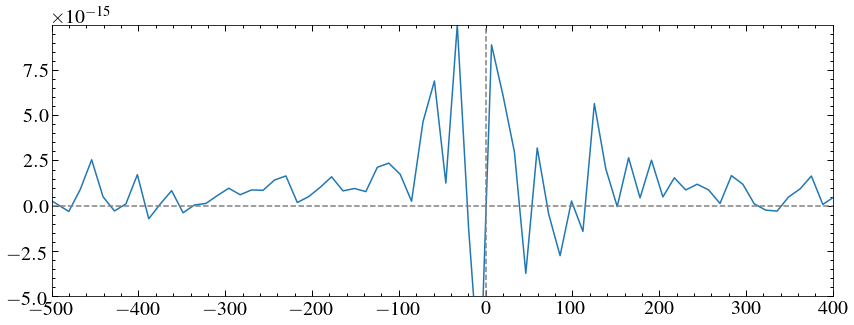

odlm41050
405.770329070397
408


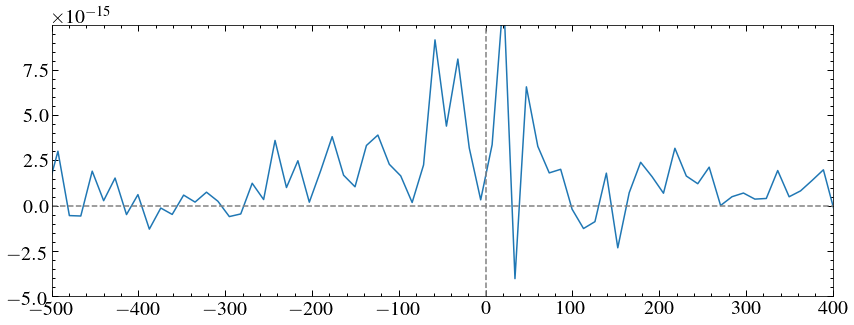

/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in true_divide
/home/david/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/david/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:422: RuntimeWarning: invalid value encountered in true_divide
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl
/home/david/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(-5e-15, 9.99e-15)

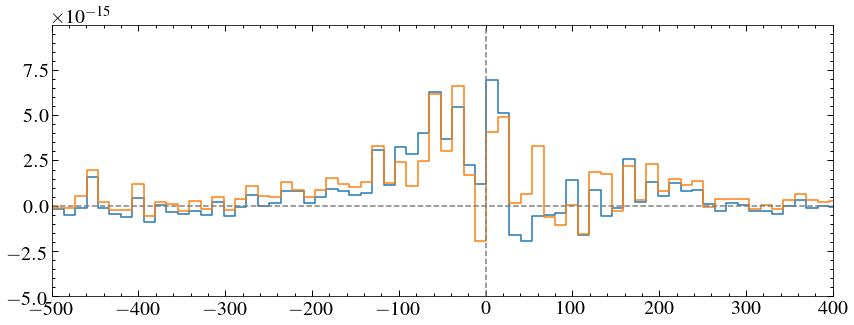

In [193]:
#for fl in glob.glob(outpath+'*.fits'):
#   os.remove(fl)

a2adjust = [-2,0,-3,-0]

f_new = []
e_new = []

bk1size=10
bk2size=10
bk1offst=-40
bk2offst=40
extrsize = [11,20,11,11]

for i, flt in enumerate(mmflts):
    hdr = fits.getheader(flt, 0)
    rootname =  hdr['ROOTNAME']
    print(rootname)
    #x = outpath+rootname+'_new_x1d.fits'
   # data = fits.getdata(x, 1)[0]
    #wi, fi, ei = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    #v = (wi*u.AA).to(u.km/u.s, equivalencies= u.doppler_optical(1215.44*u.AA))
    #plt.plot(v, fi)
    #os.remove(x)
    
    #build trace grid
    if i == 0:
        SPTRCTAB = hdr['SPTRCTAB']
        grating = hdr['OPT_ELEM']
        cenwave = hdr['CENWAVE']
        tracegrid = build_trace_grid('/home/david/crds_cache/references/hst/oref/'+SPTRCTAB[5:], grating, cenwave)
        
   
    rootarg = np.argwhere(centab['ROOTNAME']==rootname)[0][0]
    x = centab['XCOL'][rootarg]
    y = centab['A2CENTER'][rootarg]
    print (y)
    a2center = get_a2center(x,y, tracegrid)#adjust measured a2 center to central point
    print(a2center+a2adjust[i])
    stistools.x1d.x1d(flt, output=outpath+rootname+'_def_x1d.fits', verbose=False, 
                      trailer='trl_files/'+rootname+'.trl',a2center=a2center,maxsrch=0)
    x = outpath+rootname+'_def_x1d.fits'
    data = fits.getdata(x, 1)[0]
    rootname = fits.getheader(x)['ROOTNAME']
    first = True
    wi, fi, ei = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    v = (wi*u.AA).to(u.km/u.s, equivalencies= u.doppler_optical(1215.44*u.AA))
    plt.plot(v, fi)
    plt.axvline(0, ls='--', c='0.5')
    plt.axhline(0, ls='--', c='0.5')
    plt.xlim(-500, 400)
    plt.ylim(-0.5e-14, 0.999e-14)
    plt.show()
    ei = no_zero_errors(fi, ei) 
    if  first:
        w_new = wi
        first = False
    else:
        wi, fi, ei  = resample.bintogrid(wi, fi, newx=w_new, dx=ei)
    if rootname != 'odlm41040':
        f_new.append(fi)
        e_new.append(ei)


plt.step(w_dop, f_av, where='mid')
w_dop = (w_new*u.AA).to(u.km/u.s, equivalencies= u.doppler_optical(1215.44*u.AA))
f_d, e_d = new_coadd(np.array(f_new), np.array(e_new))
#plt.step(w_dop, f_av, where='mid')
#f_d = np.average(f_new, axis=0)
plt.step(w_dop, f_d, where='mid')
#plt.plot(w_dop, f_av)
plt.axvline(0, ls='--', c='0.5')
plt.axhline(0, ls='--', c='0.5')
plt.xlim(-500, 400)
plt.ylim(-0.5e-14, 0.999e-14)

In [146]:

for fl in glob.glob(outpath+'*fix_x1d.fits'):
    os.remove(fl)

a2range = [-3,-2,-1,0,1,2,3 ]
exrange = [8,9,10,11,12,13,14,15,16,17,18,19,20]
offrange = [15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]
sizerange = [5,6,7,8,9,10,11,12,13,14, 15,16,17,18,19,20, 21,22,23,24,25]

for i, flt in enumerate(mmflts):
    flya = 0.
    hdr = fits.getheader(flt, 0)
    rootname =  hdr['ROOTNAME']
    print(rootname)

    #build trace grid
    if i == 0:
        SPTRCTAB = hdr['SPTRCTAB']
        grating = hdr['OPT_ELEM']
        cenwave = hdr['CENWAVE']
        tracegrid = build_trace_grid('/home/david/crds_cache/references/hst/oref/'+SPTRCTAB[5:], grating, cenwave)
        
   
    rootarg = np.argwhere(centab['ROOTNAME']==rootname)[0][0]
    xp = centab['XCOL'][rootarg]
    yp = centab['A2CENTER'][rootarg]
    for a in a2range:  
        a2center = get_a2center(xp,yp, tracegrid)+a#adjust measured a2 center to central point
        #for b in exrange:
        for c in offrange:
            for d in sizerange:
                choices = {'a2':a2center, 'ex':11, 'off':c, 'size':d}
                stistools.x1d.x1d(flt, output=outpath+rootname+'_fix_x1d.fits', verbose=False, 
                  trailer='trl_files/'+rootname+'.trl',a2center=a2center,maxsrch=0,
                  bk1size=d, bk2size=d, bk1offst=c, bk2offst=c)
                x = outpath+rootname+'_fix_x1d.fits'
                data = fits.getdata(x, 1)[0]
                rootname = fits.getheader(x)['ROOTNAME'] 
                wi, fi, ei = data['WAVELENGTH'], data['FLUX'], data['ERROR']
                os.remove(x)
                v = (wi*u.AA).to(u.km/u.s, equivalencies= u.doppler_optical(1215.44*u.AA)).value
                mask = (v > -200) & (v < -10)
                fint = np.trapz(fi[mask], v[mask])
                if fint > flya:
                    flya = fint
                    best = choices
    print(best)
    stistools.x1d.x1d(flt, output=outpath+rootname+'_fix_x1d.fits', verbose=False, 
                      trailer='trl_files/'+rootname+'.trl',a2center=best['a2'],maxsrch=0,
                      bk1size=best['size'], bk2size=best['size'], bk1offst=best['off'], bk2offst=best['off'], extrsize=best['ex'])


odlm41020
{'a2': 407, 'ex': 11, 'off': 30, 'size': 7}
odlm41040
{'a2': 431, 'ex': 11, 'off': 32, 'size': 5}
odlm41030
{'a2': 405, 'ex': 11, 'off': 16, 'size': 18}
odlm41050
{'a2': 408, 'ex': 11, 'off': 26, 'size': 5}


In [26]:
outpath

'mm_x1ds/'

In [113]:
#odlm41020
#{'a2': 3, 'ex': 18, 'off': 26, 'size': 7}
#odlm41040
#{'a2': 3, 'ex': 20, 'off': 13, 'size': 6}
#odlm41030
#{'a2': -3, 'ex': 16, 'off': 11, 'size': 6}
#odlm41050
#{'a2': 3, 'ex': 18, 'off': 23, 'size': 5}

odlm41020


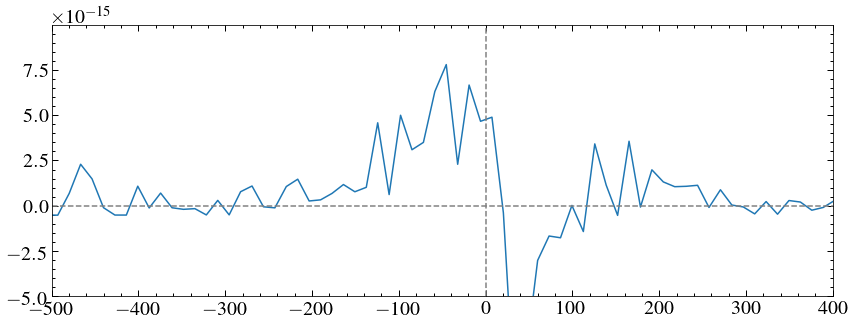

odlm41040


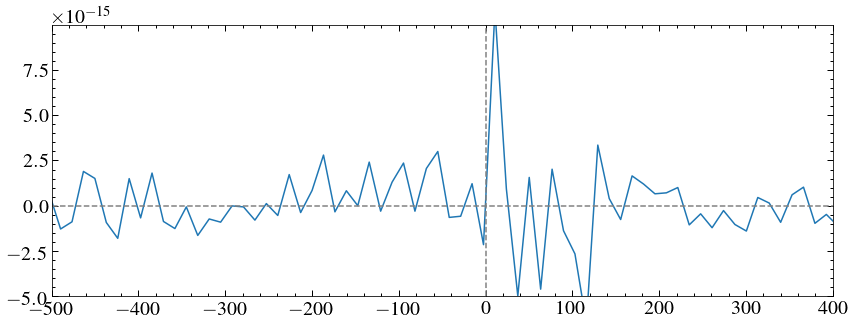

odlm41030


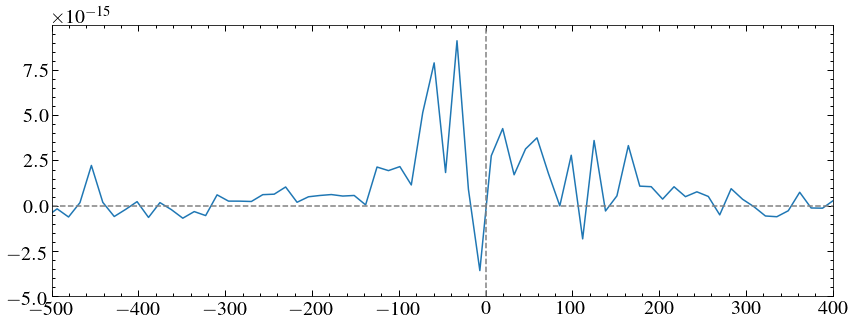

odlm41050


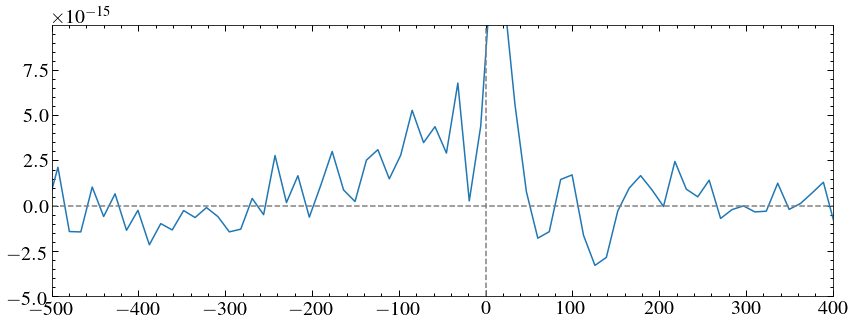

/home/david/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/david/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(-500, 400)

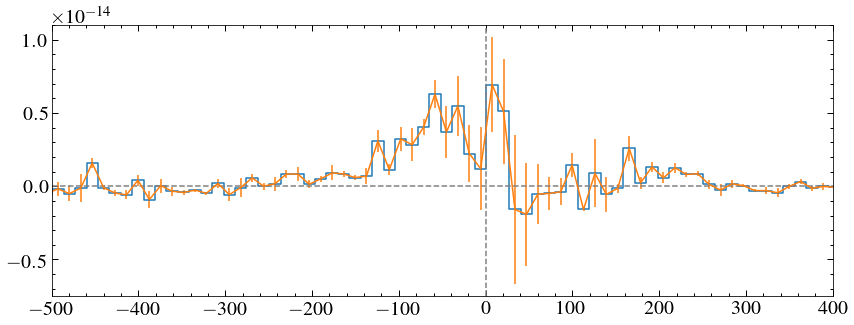

In [192]:

f_new = []
e_new = []



for i, flt in enumerate(mmflts):
    hdr = fits.getheader(flt, 0)
    rootname =  hdr['ROOTNAME']
    print(rootname)
   
    x = outpath+rootname+'_fix_x1d.fits'
    data = fits.getdata(x, 1)[0]
    rootname = fits.getheader(x)['ROOTNAME']
    first = True
    wi, fi, ei = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    v = (wi*u.AA).to(u.km/u.s, equivalencies= u.doppler_optical(1215.44*u.AA))
    plt.plot(v, fi)
    plt.axvline(0, ls='--', c='0.5')
    plt.axhline(0, ls='--', c='0.5')
    plt.xlim(-500, 400)
    plt.ylim(-0.5e-14, 0.999e-14)
    plt.show()
    ei = no_zero_errors(fi, ei) 
    if  first:
        w_new = wi
        first = False
    else:
        wi, fi, ei  = resample.bintogrid(wi, fi, newx=w_new, dx=ei)
    if rootname != 'odlm41040':
        f_new.append(fi)
        e_new.append(ei)


plt.step(w_dop, f_av, where='mid')
w_dop = (w_new*u.AA).to(u.km/u.s, equivalencies= u.doppler_optical(1215.44*u.AA))
f_av, e_av = new_coadd(np.array(f_new), np.array(e_new))
plt.errorbar(w_dop.value, f_av, yerr=e_av)
#f_av = np.average(f_new, axis=0)
#plt.(w_dop, f_av, where='mid')
#plt.plot(w_dop, f_av)
plt.axvline(0, ls='--', c='0.5')
plt.axhline(0, ls='--', c='0.5')
plt.xlim(-500, 400)
#plt.ylim(-0.5e-14, 0.999e-14)

What does the backgound look like?

odlm41020
odlm41040
odlm41030
odlm41050


(-500, 400)

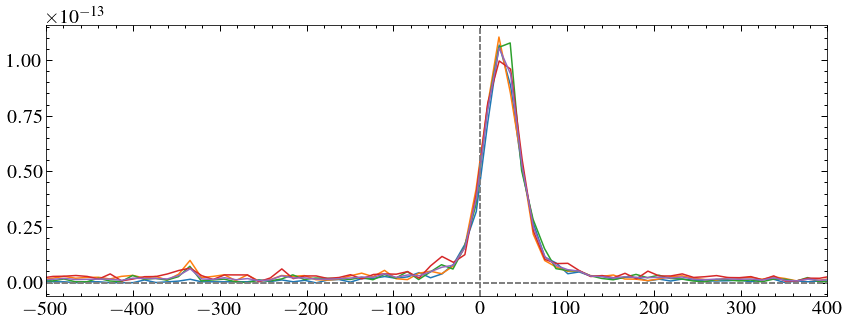

In [142]:
f_bk = []


for i, flt in enumerate(mmflts):
    hdr = fits.getheader(flt, 0)
    rootname =  hdr['ROOTNAME']
    print(rootname)
    #x = outpath+rootname+'_new_x1d.fits'
   # data = fits.getdata(x, 1)[0]
    #wi, fi, ei = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    #v = (wi*u.AA).to(u.km/u.s, equivalencies= u.doppler_optical(1215.44*u.AA))
    #plt.plot(v, fi)
    #os.remove(x)
    
    #build trace grid
    if i == 0:
        SPTRCTAB = hdr['SPTRCTAB']
        grating = hdr['OPT_ELEM']
        cenwave = hdr['CENWAVE']
        tracegrid = build_trace_grid('/home/david/crds_cache/references/hst/oref/'+SPTRCTAB[5:], grating, cenwave)
        
   
    rootarg = np.argwhere(centab['ROOTNAME']==rootname)[0][0]
    x = centab['XCOL'][rootarg]
    y = centab['A2CENTER'][rootarg]+100
    a2center = get_a2center(x,y, tracegrid)#adjust measured a2 center to central point
    stistools.x1d.x1d(flt, output=outpath+rootname+'_bk_x1d.fits', verbose=False, 
                      trailer='trl_files/'+rootname+'.trl',a2center=500,maxsrch=0,
                      backcorr=None)
    x = outpath+rootname+'_bk_x1d.fits'
    data = fits.getdata(x, 1)[0]
    os.remove(x)
    wi, fi, ei = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    v = (wi*u.AA).to(u.km/u.s, equivalencies= u.doppler_optical(1215.44*u.AA))
    plt.plot(v, fi)
    plt.axvline(0, ls='--', c='0.5')
    plt.axhline(0, ls='--', c='0.5')
    plt.xlim(-500, 400)
    #plt.ylim(-0.5e-14, 0.999e-14)
    #plt.show()
    ei = no_zero_errors(fi, ei) 
    if  first:
        w_new = wi
        first = False
    else:
        wi, fi  = resample.bintogrid(wi, fi, newx=w_new)
    
    f_bk.append(fi)

w_dop = (w_new*u.AA).to(u.km/u.s, equivalencies= u.doppler_optical(1215.44*u.AA))

bk_av = np.average(f_bk, axis=0)
plt.plot(w_dop, bk_av)
plt.axvline(0, ls='--', c='0.5')
plt.axhline(0, ls='--', c='0.5')
plt.xlim(-500, 400)
#plt.ylim(-0.5e-14, 0.999e-14)


In [1]:
#for fl in glob.glob(outpath+'*.fits'):
#   os.remove(fl)

f_b17 = []
e_b17 = []



for i, flt in enumerate(mmflts):
    hdr = fits.getheader(flt, 0)
    rootname =  hdr['ROOTNAME']
    print(rootname)
    #x = outpath+rootname+'_new_x1d.fits'
   # data = fits.getdata(x, 1)[0]
    #wi, fi, ei = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    #v = (wi*u.AA).to(u.km/u.s, equivalencies= u.doppler_optical(1215.44*u.AA))
    #plt.plot(v, fi)
    #os.remove(x)
    
    #build trace grid
    if i == 0:
        SPTRCTAB = hdr['SPTRCTAB']
        grating = hdr['OPT_ELEM']
        cenwave = hdr['CENWAVE']
        tracegrid = build_trace_grid('/home/david/crds_cache/references/hst/oref/'+SPTRCTAB[5:], grating, cenwave)
        
   
    rootarg = np.argwhere(centab['ROOTNAME']==rootname)[0][0]
    x = centab['XCOL'][rootarg]
    y = centab['A2CENTER'][rootarg]
    print (y)
    a2center = get_a2center(x,y, tracegrid)#adjust measured a2 center to central point
    print(a2center+a2adjust[i])
    stistools.x1d.x1d(flt, output=outpath+rootname+'_final_x1d.fits', verbose=False, 
                      trailer='trl_files/'+rootname+'.trl',a2center=a2center,maxsrch=0,
                      bk1size=14, bk2size=14, bk1offst=14, bk2offst=14)
    x = outpath+rootname+'_final_x1d.fits'
    data = fits.getdata(x, 1)[0]
    rootname = fits.getheader(x)['ROOTNAME']
    first = True
    wi, fi, ei = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    v = (wi*u.AA).to(u.km/u.s, equivalencies= u.doppler_optical(1215.44*u.AA))
    plt.plot(v, fi)
    plt.axvline(0, ls='--', c='0.5')
    plt.axhline(0, ls='--', c='0.5')
    plt.xlim(-500, 400)
    plt.ylim(-0.5e-14, 0.999e-14)
    plt.show()
    ei = no_zero_errors(fi, ei) 
    if  first:
        w_new = wi
        first = False
    else:
        wi, fi, ei  = resample.bintogrid(wi, fi, newx=w_new, unc=ei)
    if rootname != 'odlm41040':
        f_b17.append(fi)
        e_b17.append(ei)


plt.step(w_dop, f_av, where='mid')
w_dop = (w_new*u.AA).to(u.km/u.s, equivalencies= u.doppler_optical(1215.44*u.AA))
#f_av, e_av = new_coadd(np.array(f_new), np.array(e_new))
#plt.step(w_dop, f_av, where='mid')
f_avb = np.average(f_b17, axis=0)
plt.step(w_dop, f_avb, where='mid')
#plt.plot(w_dop, f_av)
plt.axvline(0, ls='--', c='0.5')
plt.axhline(0, ls='--', c='0.5')
plt.xlim(-500, 400)
plt.ylim(-0.5e-14, 0.999e-14)

NameError: name 'mmflts' is not defined

Considerably smaller. Final choice: Vaired fit, removing odlm41040, and adding a background column

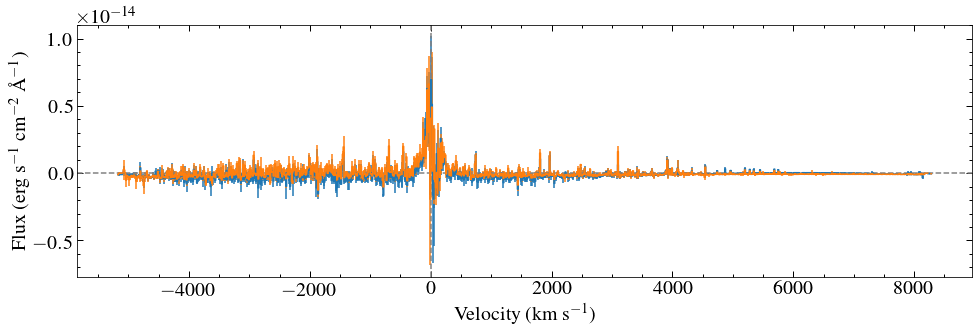

In [197]:
plt.errorbar(w_dop.value, f_av, yerr=e_av, drawstyle ='steps-mid')
plt.errorbar(w_dop.value, f_d, yerr=e_d, drawstyle ='steps-mid')
#plt.xlim(-500, 400)
#plt.plot(w_dop, bk_av)
#plt.ylim(-0.1e-14, 0.999e-14)

#plt.plot(w_dop, bk_av-np.median(bk_av))
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.xlabel('Velocity (km s$^{-1}$)')
plt.axvline(0, ls='--', c='0.5')
plt.axhline(0, ls='--', c='0.5')
plt.tight_layout()
#plt.savefig('mm_t1_lya.png')

In [181]:
savedat = Table([w_new*u.AA, w_dop, f_av*u.erg/u.s/u.cm**2/u.AA, e_av*u.erg/u.s/u.cm**2/u.AA, bk_av*u.erg/u.s/u.cm**2/u.AA], names = ['WAVELENGTH', 'VELOCITY', 'FLUX', 'ERROR', 'BACKGROUND'])
ascii.write(savedat, 'mm_trappist-1_g140m.ecsv', format='ecsv', overwrite=True)

In [195]:
savedat = Table([w_new*u.AA, w_dop, f_d*u.erg/u.s/u.cm**2/u.AA, e_d*u.erg/u.s/u.cm**2/u.AA, bk_av*u.erg/u.s/u.cm**2/u.AA], names = ['WAVELENGTH', 'VELOCITY', 'FLUX', 'ERROR', 'BACKGROUND'])
ascii.write(savedat, 'mm_trappist-1_g140m_default.ecsv', format='ecsv', overwrite=True)

Fixing new lya file

In [212]:
lya = Table.read('../lya/TRAPPIST1_LyA_profiles.txt', format='ascii')
#lya

In [216]:
lyadat = Table([lya['col1'], lya['col2']+lya['col3']], names=['WAVELENGTH','FLUX'])
ascii.write(lyadat, '../lya/Trappist-1_lya_simple.txt', overwrite=True)

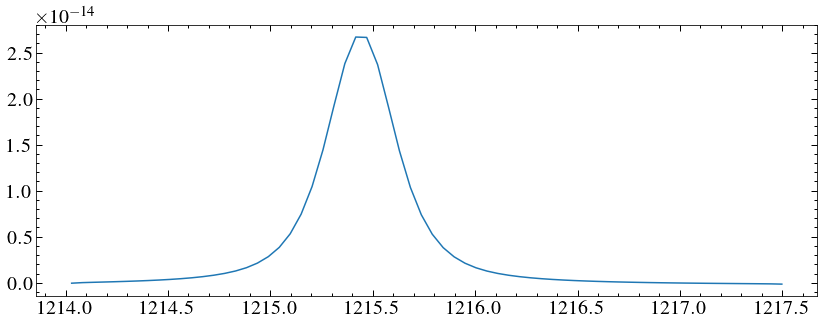

In [217]:
plt.plot(lya['col1'], lya['col2']+lya['col3'])

NameError: name 'w_new' is not defined